In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
    
# Set a random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Input, Conv1D, Flatten, Dense, Reshape, Conv1DTranspose
from keras.models import Model
from keras.models import clone_and_build_model
from keras.callbacks import EarlyStopping

In [2]:
from helper_function import *

# Deep Learning Model Implementation

In [22]:


def AutoencoderModel(InputFeature):
    # Define input layer
    input_layer = Input(shape=(InputFeature.shape[1], InputFeature.shape[2]))
    
    # Encoder part
    input_layer = Input(shape=(InputFeature.shape[1], InputFeature.shape[2]))
    x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    shape1=x.get_shape()[1:]
    x = Flatten()(x)
    shape2 = x.get_shape()[1]
    x = Dense(128,activation='relu',name="encoder_last")(x)
    d = Dense(shape2,activation='relu')(x)
    d = Reshape(shape1)(d)
    d = Conv1DTranspose(32, 3, strides=1, activation='relu', padding='same')(d)
    d = Conv1DTranspose(6, 3, strides=1, activation='linear', padding='same')(d)
    
    # Define the autoencoder model
    autoencoder = Model(input_layer, d)
    
    # Compile the model with mean squared error (MSE) loss function and Adam optimizer
    autoencoder.compile(loss='mean_squared_error', optimizer='adam')
    
    return autoencoder

In [23]:
# Import the data
data = pd.read_csv("Electrolyzer_faults.csv")
X,Y,Z = sliding_window(data, window_size=40, stride=1)

sc= StandardScaler()
X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)

x_train, x_test, z_train, z_test = train_test_split(X_sc, Z, test_size=0.2)

# Add noise to the input value

In [24]:
def add_noise(x):
    # Define the scale of the random noise
    noise_scale = 0.2

    # Generate random noise with the same shape as x_train
    noise = np.random.uniform(0, noise_scale, x.shape)

    # Add the noise to x_train
    x_with_noise = x + noise
    return x_with_noise

In [25]:
x_train_with_noise = add_noise(x_train)
x_test_with_noise = add_noise(x_test)

# Pretraining using hybrid method

In [7]:
from keras.callbacks import EarlyStopping

#Pretraining using pseudo labels
psuedo_label_model = DeepLearningModel(x_train, z_train,last_layer_activation='sigmoid',loss_fn='binary_crossentropy')
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = psuedo_label_model.fit(x_train, z_train, epochs=500, batch_size=128, validation_data=(x_test, z_test), callbacks=[early_stop])

Epoch 1/500
29/29 [==============================] - 1s 19ms/step - loss: 0.4634 - binary_accuracy: 0.8344 - val_loss: 0.2471 - val_binary_accuracy: 0.9159
Epoch 2/500
29/29 [==============================] - 0s 9ms/step - loss: 0.1777 - binary_accuracy: 0.9322 - val_loss: 0.1296 - val_binary_accuracy: 0.9535
Epoch 3/500
29/29 [==============================] - 0s 9ms/step - loss: 0.1183 - binary_accuracy: 0.9565 - val_loss: 0.1063 - val_binary_accuracy: 0.9606
Epoch 4/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0970 - binary_accuracy: 0.9640 - val_loss: 0.0846 - val_binary_accuracy: 0.9672
Epoch 5/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0825 - binary_accuracy: 0.9679 - val_loss: 0.0763 - val_binary_accuracy: 0.9680
Epoch 6/500
29/29 [==============================] - 0s 8ms/step - loss: 0.0767 - binary_accuracy: 0.9707 - val_loss: 0.0715 - val_binary_accuracy: 0.9689
Epoch 7/500
29/29 [==============================] - 0s 9ms/step - lo

# Pretraining Autoencoder

Epoch 1/200
27/27 [==============================] - 1s 22ms/step - loss: 0.6295 - val_loss: 0.3075
Epoch 2/200
27/27 [==============================] - 0s 12ms/step - loss: 0.2398 - val_loss: 0.1956
Epoch 3/200
27/27 [==============================] - 0s 14ms/step - loss: 0.1628 - val_loss: 0.1271
Epoch 4/200
27/27 [==============================] - 0s 14ms/step - loss: 0.1068 - val_loss: 0.0927
Epoch 5/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0854 - val_loss: 0.0784
Epoch 6/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0727 - val_loss: 0.0706
Epoch 7/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0637 - val_loss: 0.0614
Epoch 8/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0559 - val_loss: 0.0546
Epoch 9/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0507 - val_loss: 0.0503
Epoch 10/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0466 - val_loss: 0.0475

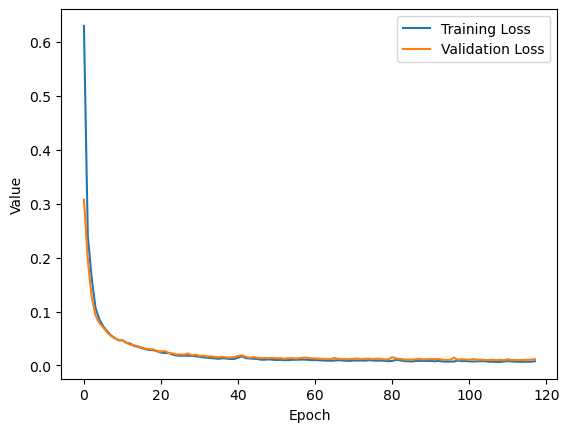

In [26]:

nn_model = AutoencoderModel(X_sc)
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = nn_model.fit(x_train_with_noise, x_train, epochs=200, batch_size=128, validation_data=(x_test_with_noise, x_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

encoder = Model(inputs=nn_model.input,outputs=nn_model.get_layer("encoder_last").output)
encoder.summary()

16/16 [==============================] - 0s 2ms/step


c:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


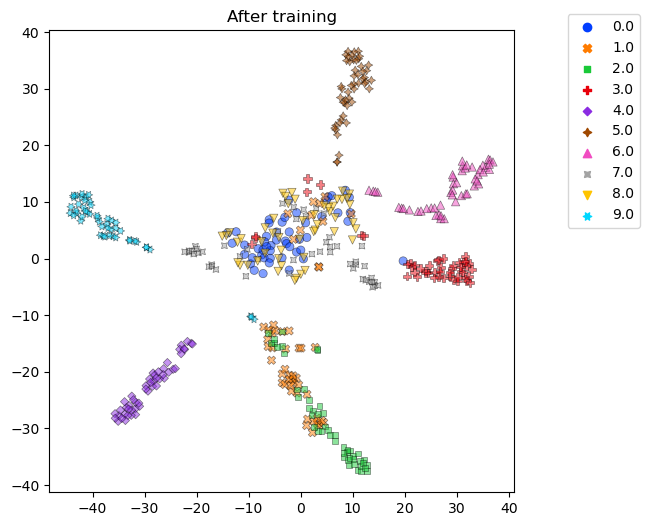

In [10]:
Visualize_last_layer(encoder,X_sc,Y,Z)

# Fine Tune the AE model

In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

In [27]:
def FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe):
    nn_model.compile()

    from keras.layers import BatchNormalization
    from keras.models import clone_and_build_model

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model_copy= clone_and_build_model(nn_model)
    model_copy.set_weights(weights=nn_model.get_weights())

    intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-2].output)

    for l in intermediate_model.layers:
        l.trainable=False

    fine_tuned_layers = Dense(units=64,activation='relu')(intermediate_model.output)
    output_layer = Dense(units=Y_ohe.shape[1],activation='softmax')(fine_tuned_layers)

    # Define the model
    fine_tuned_model = Model(inputs=intermediate_model.input, outputs=output_layer)

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    fine_tuned_model.fit(x_train, y_train, epochs=500, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    for l in fine_tuned_model.layers:
        l.trainable=True

    # Create a custom Adam optimizer with a small learning rate
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Compiling again is necessary to update the trainable parameter before training
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    fine_tuned_model.fit(x_train, y_train, epochs=50, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    return fine_tuned_model

In [32]:
from sklearn.metrics import f1_score, accuracy_score

set_of_samples = [4, 8, 16, 32, 64, 90]
num_repetitions = 5

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("FineTuned Model Training")
F1_score_finetuned = np.zeros((num_repetitions, len(set_of_samples)))

for repetition in range(num_repetitions):
    print(f"**************** repetation - {repetition+1} ****************")
    for i, samples in enumerate(set_of_samples):
        print(f'Repetition {repetition + 1}: Training samples per class = {samples}')
 
        x_val, y_val, _ = Resample(X_sc, Y, Z, samples)
        y_val = ohe.transform(y_val.reshape(-1, 1))

        fine_tuned_model = FineTunedModel(encoder,x_val,y_val,X_sc,Y_ohe)
        
        x_train,y_train,z_train = Resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = fine_tuned_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        print(f'F1 score on whole dataset = {f1}')
        F1_score_finetuned[repetition, i] = f1

print("F1 Scores Matrix:")
print(F1_score_finetuned)

FineTuned Model Training
**************** repetation - 1 ****************
Repetition 1: Training samples per class = 4
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.7475991228421881
Repetition 1: Training samples per class = 8
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.7754858434017019
Repetition 1: Training samples per class = 16
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.8554980804202869
Repetition 1: Training samples per class = 32
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.9342945891148468
Repetition 1: Training samples per class = 64
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.913983993597439
Repetition 1: Training samples per class = 90
16/16 [==============================] - 0s 3ms/step
F1 score on whole dataset = 0.9179599911971991
**************** repetation - 2 ****************
Repe

# Save the experiment in csv file

In [33]:
mean_f1_scores_ae = np.mean(F1_score_finetuned, axis=0)
variance_f1_scores_ae= np.var(F1_score_finetuned, axis=0)

results_dict = {
    'No training samples': set_of_samples,
    'Model': ['AE'] * len(set_of_samples) ,
    'Mean F1 score': mean_f1_scores_ae,
    'Error': variance_f1_scores_ae
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Save the DataFrame to a CSV file
results_df.to_csv('SOA1_DAE.csv', index=False)

# The proposed hybrid model

In [215]:

# Create fullySupervided NEtwork
print("Propose hybrid method")
F1_score_hybrid = np.zeros((num_repetitions, len(set_of_samples)))

for repetition in range(num_repetitions):
    for i, samples in enumerate(set_of_samples):
        print(f'Repetition {repetition + 1}: Training samples per class = {samples}')
        x_val, y_val, _ = resample(X_sc, Y,Z, samples)
        y_val_ohe = ohe.transform(y_val.reshape(-1, 1))

        hybrid_model = FineTunedModel(psuedo_label_model,x_val,y_val_ohe,X_sc,Y_ohe)
        
        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = hybrid_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        y_pred = Cascade_Hybrid_FDI(x_train,z_train,y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        print(f'F1 score on whole dataset = {f1}')
        F1_score_hybrid[repetition, i] = f1

print("F1 Scores Matrix:")
print(F1_score_hybrid)

Propose hybrid method
Repetition 1: Training samples per class = 4


16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.8488193164231805
Repetition 1: Training samples per class = 8
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.8662304027095846
Repetition 1: Training samples per class = 16
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.8624195965591503
Repetition 1: Training samples per class = 32
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.9030627238470263
Repetition 1: Training samples per class = 64
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.9011671216715612
Repetition 1: Training samples per class = 90
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.9049132358258264
Repetition 2: Training samples per class = 4
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.8461835524401323
Repetition 2: Training sam

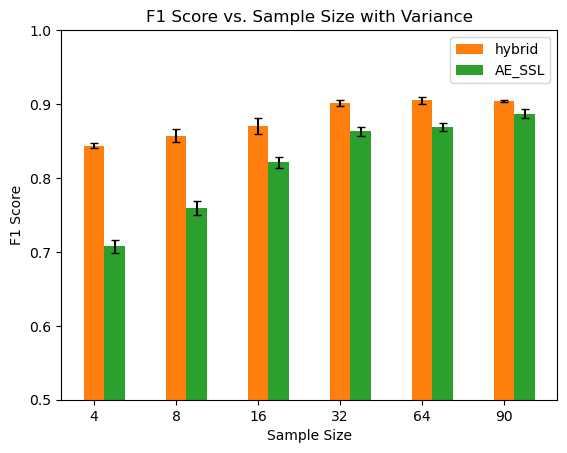

In [217]:
import numpy as np
import matplotlib.pyplot as plt

set_of_samples = [4, 8, 16, 32, 64, 90]

# Calculate the mean and variance of F1 scores for each sample size


mean_f1_scores_hybrid = np.mean(F1_score_hybrid, axis=0)
variance_f1_scores_hybrid = np.var(F1_score_hybrid, axis=0)

mean_f1_scores_ae = np.mean(F1_score_finetuned, axis=0)
variance_f1_scores_ae= np.var(F1_score_finetuned, axis=0)

# Set the width of each bar
bar_width = 0.25

# Create an array representing the x-axis positions
x = np.arange(len(set_of_samples))

# Choose colors for three classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create side-by-side bar plots with error bars
plt.bar(x, mean_f1_scores_hybrid, bar_width, yerr=np.sqrt(variance_f1_scores_hybrid), capsize=3, color=colors[1], label='hybrid')
plt.bar(x + bar_width, mean_f1_scores_ae, bar_width, yerr=np.sqrt(variance_f1_scores_ae), capsize=3, color=colors[2], label='AE_SSL')

plt.grid(visible=False)
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('F1 Score')
plt.ylim([0.5,1])
plt.title('F1 Score vs. Sample Size with Variance')
plt.xticks(x, [str(x) for x in set_of_samples])
plt.show()
